# Multi-GPU demo
pyclesperanto allows processing images on multiple GPUs in parallel. Therefore, you need to create multiple clesperanto/GPU handles, such as `cle1`, `cle2`, ...

In [7]:
from skimage.io import imread, imshow
import pyclesperanto as cle
import time
import numpy as np

In [2]:
cle.list_available_devices()

['AMD Ryzen 9 7950X 16-Core Processor',
 'NVIDIA GeForce RTX 4090',
 'NVIDIA GeForce RTX 4090']

In [3]:
cle.info()

0 - (OpenCL) AMD Ryzen 9 7950X 16-Core Processor (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2024.18.10.0.08_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Maximum Object Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes
1 - (OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24183 MB
	Maximum Object Size:         6045 MB
	Max Clock Frequency:         2520 MHz
	Image Support:               Yes
2 - (OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24

We can see that my system has various devices which are compatible with pyclesperanto. Two GPUs from NVIDIA and one CPU from AMD.
For proper processing we would want to rely on the two GPUs, but for this example we will use one GPU and the CPU.

In [4]:
device_1 = cle.select_device(0)
device_2 = cle.select_device(1)

In [5]:
print(device_1.info)
print(device_2.info)

(OpenCL) AMD Ryzen 9 7950X 16-Core Processor (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2024.18.10.0.08_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Maximum Object Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.216.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24183 MB
	Maximum Object Size:         6045 MB
	Max Clock Frequency:         2520 MHz
	Image Support:               Yes



We have now our two devices, we can use them to run some processing.
You can use these two handles by providing them as `device` parameter when calling any operation from pyclesperanto.

Let's load an image an process it once with our GPU and then with ou CPU.

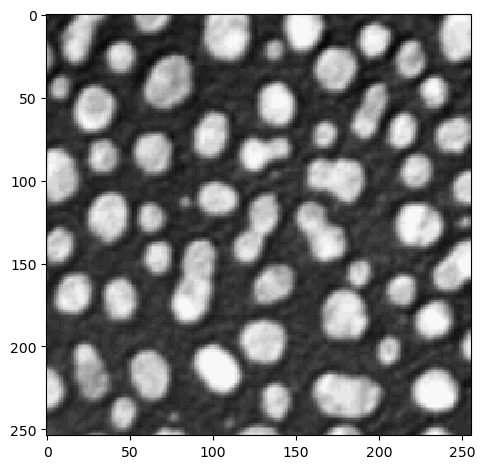

In [8]:
image = imread("https://samples.fiji.sc/blobs.png").squeeze()
imshow(image)

When pushing my image to my devices, we can specify which device we are pushing to with the `device` parameter.

In [18]:
image1 = cle.push(image, device=device_1)
image2 = cle.push(image, device=device_2)

print("image 1:",type(image1), "device:", image1.device.name)
print("image 2:",type(image2), "device:", image2.device.name)

image 1: <class 'pyclesperanto._pyclesperanto._Array'> device: 0x63f4b0721bd0
image 2: <class 'pyclesperanto._pyclesperanto._Array'> device: 0x63f4b13db290


Although both `image1` and `image2` are `pyclesperanto_.Array_`, they are not on the same device.
We can call operation the usual way and each device will take charge of their data.

In [12]:
blurred1 = cle.gaussian_blur(image1, sigma_x=10)
blurred2 = cle.gaussian_blur(image2, sigma_y=5)

array([[ 40.09867 ,  41.156883,  42.507847, ..., 189.27463 , 192.13885 ,
        194.54207 ],
       [ 50.640034,  51.278248,  52.21751 , ..., 202.75032 , 205.77882 ,
        208.34549 ],
       [ 56.174618,  56.587578,  57.299023, ..., 214.51335 , 217.79279 ,
        220.61708 ],
       ...,
       [ 69.12755 ,  68.62755 ,  68.08486 , ...,  63.774853,  61.41017 ,
         59.30248 ],
       [ 73.342476,  72.481384,  71.57082 , ...,  68.137054,  65.15865 ,
         62.49601 ],
       [ 82.46705 ,  81.12341 ,  79.76445 , ...,  72.538284,  69.047844,
         65.90595 ]], dtype=float32, mtype=buffer)
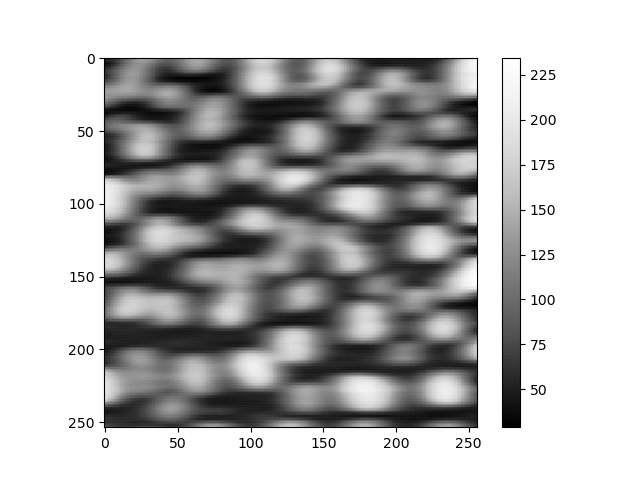
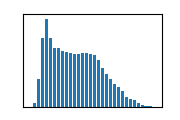

In [13]:
blurred1

array([[ 40.902157,  35.52846 ,  28.573563, ..., 225.0747  , 212.74393 ,
        212.74393 ],
       [ 40.74715 ,  36.183662,  29.756958, ..., 226.44624 , 214.88696 ,
        214.88696 ],
       [ 40.56795 ,  36.867207,  31.014425, ..., 227.67151 , 216.88551 ,
        216.88551 ],
       ...,
       [ 76.24275 ,  76.07471 ,  72.87162 , ...,  47.891773,  49.061604,
         49.061604],
       [ 79.090904,  77.96503 ,  74.195816, ...,  47.923836,  48.865387,
         48.865387],
       [ 81.93995 ,  79.81    ,  75.43991 , ...,  47.94881 ,  48.678455,
         48.678455]], dtype=float32, mtype=buffer)
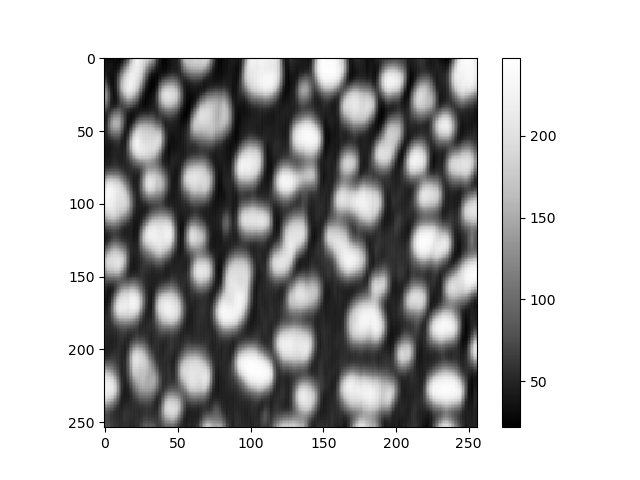
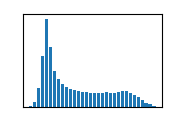

In [14]:
blurred2

For demonstration purposes, we will execute a Gaussian blur with a wide radius on a large data randomly generated and time it. We should see that this operation takes some time depending on which device is running.

In [15]:
# create a 100 MB test image
test_image = np.random.random((10, 1000, 1000)).astype(float)

# push the image to memory of both GPUs.
image1 = cle.push(test_image, device=device_1)
image2 = cle.push(test_image, device=device_2)

# we wait here for a second to make sure the images arrived
time.sleep(1)

In [16]:
image1.shape, image2.shape

((10, 1000, 1000), (10, 1000, 1000))

We now execute the Gaussian blur on both devices sequentially a couple of times and measure the time it takes.

In [19]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on first GPU
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from first GPU
    result1 = cle.pull(blurred1)
    t1 = time.time() - start_time
    print("Processing and pulling on", blurred1.device.name, "took", t1)
    
    start_time = time.time()
    # process image on second GPU
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from second GPU
    result2 = cle.pull(blurred2)
    t2 = time.time() - start_time
    print("Processing and pulling on", blurred2.device.name, "took", t2)   
    
    

-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.020035743713378906
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.001188516616821289
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.01710367202758789
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.0012083053588867188
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.015828847885131836
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.0012187957763671875
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.01612091064453125
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.001142263412475586
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.015565633773803711
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.0011899471282958984


You can clearly see that one device, the CPU, is a bit slower than the other one, the GPU. We now repeat that experiment with a different call-order. If processing is done in parallel in the background, we will see that the processing time of each for-loop iteration is less than in the example above. 

In [20]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on both GPUs
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)

    # retrieve result from both GPUs
    result1 = cle.pull(blurred1)
    result2 = cle.pull(blurred2)
    print("Processing and pulling on", blurred1.device.name, "and", blurred2.device.name, "in parallel took", time.time() - start_time)

-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor and NVIDIA GeForce RTX 4090 in parallel took 0.03801536560058594
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor and NVIDIA GeForce RTX 4090 in parallel took 0.01799154281616211
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor and NVIDIA GeForce RTX 4090 in parallel took 0.016455411911010742
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor and NVIDIA GeForce RTX 4090 in parallel took 0.017154932022094727
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor and NVIDIA GeForce RTX 4090 in parallel took 0.016885042190551758


we can now run different kernels on different devices at the same time. 
  
Enjoy!